# Learn Swiss from Moons
In this notebook, we want to train a neural network than can transform the Moons distribution to Swiss distribution.

## Dataset
We collect some generic function from previous notebooks. The target distribution looks like: 

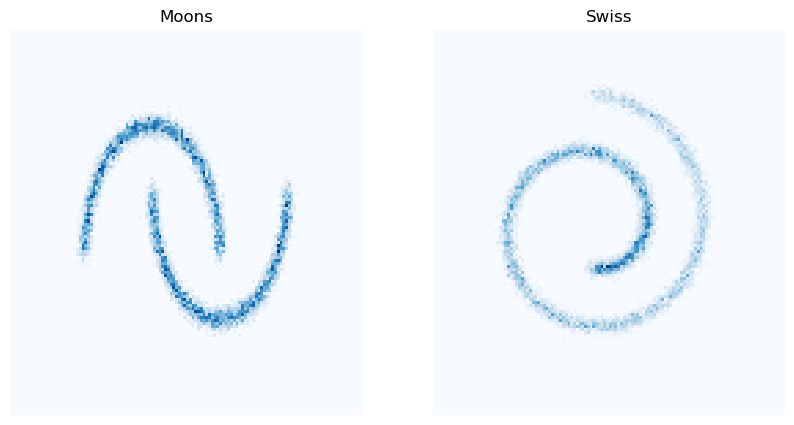

In [1]:
from utils import get_data, plot_dist, Net, wasserstein_distance
import matplotlib.pyplot as plt

moons_np = get_data('moons',n_points=1024*10)
swiss_np = get_data('swiss',n_points=1024*10)
fig,axs=plt.subplots(1,2,figsize=(10,5))
plot_dist(moons_np,ax=axs[0],title='Moons')
plot_dist(swiss_np,ax=axs[1],title='Swiss')
plt.show()

Train the flow matching

In [2]:
from distrans.flowmatching import TwoSideOTCondFlowMatcher
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
moons=torch.from_numpy(moons_np).to(device,dtype=torch.float32)
swiss=torch.from_numpy(swiss_np).to(device,dtype=torch.float32)
datas=torch.cat([moons,swiss],dim=-1)
data_loader=torch.utils.data.DataLoader(datas,batch_size=10240,shuffle=True)
network=Net().to(device)
optimizer=torch.optim.AdamW(network.parameters(),lr=1e-3)
flow_matcher=TwoSideOTCondFlowMatcher()
p_bar=tqdm(range(2000))
train_losses=[]
for epoch in p_bar:
    for data in data_loader:
        optimizer.zero_grad()
        loss=flow_matcher.cfm_loss(network,x_0=data[...,0:2],x_1=data[...,2:])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        p_bar.set_description(f'Loss: {train_losses[-1]:.4f}')

Loss: 1.1452: 100%|██████████| 2000/2000 [01:08<00:00, 29.19it/s]


Check the final result

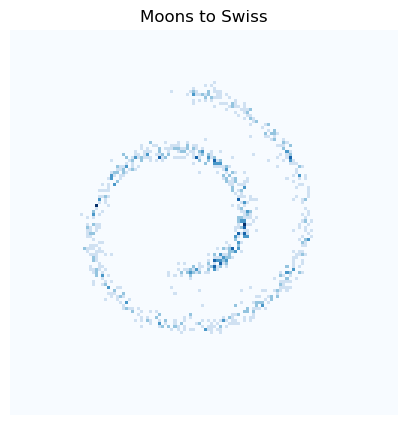

In [3]:
moons_test=torch.from_numpy(get_data('moons',n_points=1000)).to(device,dtype=torch.float32)
swiss_test=torch.from_numpy(get_data('swiss',n_points=1000)).to(device,dtype=torch.float32)
predictions=flow_matcher.fixed_step_sample(network,moons_test,num_steps=50,full_trajectory=True)
plot_dist(predictions[-1],title='Moons to Swiss')

In [4]:
from matplotlib import animation
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
fig, ax = plt.subplots()
def animate(i):
    plt.cla()
    ax.axis('off')
    wd=wasserstein_distance(predictions[i],swiss_test)
    plot_dist(predictions[i],title=f'Step {i}, WD: {wd:.4f}',ax=ax)
    
animation.FuncAnimation(fig=fig, func=animate, frames=len(predictions))